## Setup

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pandas as pd

# Prepare training and test data
training_data = datasets.MNIST(root="../../data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="../../data", train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(training_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)

c:\Users\Xyrion\Anaconda3\envs\deep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9912422/9912422 [00:00<00:00, 31669493.64it/s]


Extracting ../../data\MNIST\raw\train-images-idx3-ubyte.gz to ../../data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28855572.61it/s]


Extracting ../../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../../data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17541359.29it/s]


Extracting ../../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4672683.04it/s]

Extracting ../../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data\MNIST\raw



# Main

## Functions

In [3]:
# Image Getter Functions

def extract_idx(dataset, target):
    idx = (dataset.targets == target)
    res = []
    for i,v in enumerate(idx):
        if v:
            res.append(i)
    return res

def extract_idx_all(dataset):
    res = []
    for i in range(10):
        res.append(extract_idx(dataset, i))
    return res

idx_all = extract_idx_all(training_data)

def get_rand_img(target):
    return idx_all[target][random.randrange(0,len(idx_all[target]))]

def get_rand_img_class(dataset, target):
    # idx = extract_idx(dataset, target)
    # return dataset[idx[random.randrange(0,len(idx))]][0]
    return dataset[get_rand_img(target)][0]




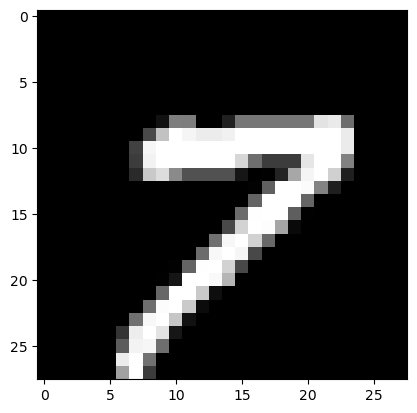

In [5]:
image = get_rand_img_class(training_data, 7)
plt.imshow(image.permute(1, 2, 0), cmap='gist_gray')

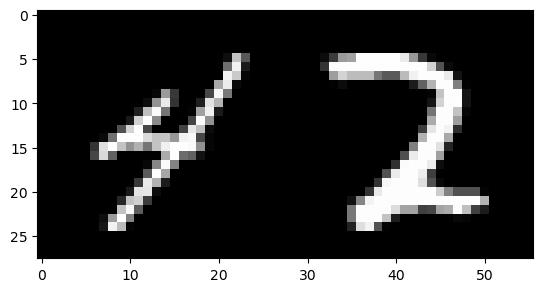

In [8]:
image4 = get_rand_img_class(training_data, 4)
image2 = get_rand_img_class(training_data, 2)

stacked = torch.cat([image4, image2], dim=2)
plt.imshow(stacked.permute(1, 2, 0), cmap='gist_gray')

## Model

In [9]:
# Define network
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
 
    def forward(self, x):
        return self.conv_stack(x)

In [10]:
def train_loop(data_loader, model, loss_function, optimizer):
    mean_loss, n_correct = 0, 0

    for batch, (data, labels) in enumerate(data_loader):
        # Feed data through network and compute loss.
        prediction = model(data)
        loss = loss_function(prediction, labels)
 
        # Zero gradients.
        optimizer.zero_grad()
 
        # Perform backpropagation and accumulate gradients.
        loss.backward()
 
        # Update network parameters.
        optimizer.step()

        mean_loss += loss.detach().item()
        n_correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()
    
    return n_correct / len(data_loader.dataset), mean_loss / len(data_loader)

def test_loop(data_loader, model, loss_function):
    mean_loss, n_correct = 0, 0
 
    with torch.no_grad():
        for data, labels in data_loader:
            # Feed data through network and accumulate loss.
            prediction = model(data)
            
            mean_loss += loss_function(prediction, labels).item()
            n_correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()
 
    return n_correct / len(data_loader.dataset), mean_loss / len(data_loader)

In [11]:
model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    print(f' Epoch {epoch+1:02}: ', end='\t')
    train_acc, train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    print(f'Train Accuracy: {train_acc:.2%},', f'Train Loss: {train_loss:.4}', end=',\t')
    test_acc, test_loss = test_loop(test_data_loader, model, loss_fn)
    print(f'Test Accuracy: {test_acc:.2%},', f'Test Loss: {test_loss:.4}')

 Epoch 01: 	Train Accuracy: 92.24%, Train Loss: 0.2676,	Test Accuracy: 96.20%, Test Loss: 0.1138
 Epoch 02: 	Train Accuracy: 97.56%, Train Loss: 0.07979,	Test Accuracy: 97.77%, Test Loss: 0.06427
 Epoch 03: 	Train Accuracy: 98.26%, Train Loss: 0.05701,	Test Accuracy: 98.21%, Test Loss: 0.05074
 Epoch 04: 	Train Accuracy: 98.64%, Train Loss: 0.04394,	Test Accuracy: 98.60%, Test Loss: 0.04137
 Epoch 05: 	Train Accuracy: 98.91%, Train Loss: 0.03553,	Test Accuracy: 98.86%, Test Loss: 0.03664
 Epoch 06: 	Train Accuracy: 99.13%, Train Loss: 0.02891,	Test Accuracy: 98.88%, Test Loss: 0.03715
 Epoch 07: 	Train Accuracy: 99.31%, Train Loss: 0.02392,	Test Accuracy: 98.66%, Test Loss: 0.0405
 Epoch 08: 	Train Accuracy: 99.42%, Train Loss: 0.01981,	Test Accuracy: 98.67%, Test Loss: 0.04194
 Epoch 09: 	Train Accuracy: 99.47%, Train Loss: 0.01677,	Test Accuracy: 98.77%, Test Loss: 0.04252
 Epoch 10: 	Train Accuracy: 99.52%, Train Loss: 0.01485,	Test Accuracy: 98.64%, Test Loss: 0.04749


## Wrapper

In [12]:
class Adder(nn.Module):
    def __init__(self, model, dataset):
        super(Adder, self).__init__()
        self.model = model
        self.dataset = dataset

    def forward(self, input_images, debug=False):
        res = 0
        for input_image in input_images:
            res += model(input_image.view(1, 1, 28, 28)).argmax(1).item()

        if debug:
            return res

        return self.create_image(res)

    def create_image(self, number):
        image_list = []
        for char in str(number):
            image = get_rand_img_class(self.dataset, int(char))
            image_list.append(image)
        return torch.cat(image_list, dim=2)

adder = Adder(model, training_data)

In [13]:
def get_rand_img_list(adder, number_list):
    image_list = []
    for number in number_list:
        image = get_rand_img_class(adder.dataset, number)
        image_list.append(image)
    return image_list

def test_addition(adder, number_list):
    image_list = get_rand_img_list(adder, number_list)
    images = torch.stack(image_list)

    print(*number_list, sep=' + ')
    plt.imshow(torch.cat(image_list, dim=2).permute(1, 2, 0), cmap='gist_gray')
    plt.show()

    output = adder(images)

    print(f' = {sum(number_list)}')
    plt.imshow(output.permute(1, 2, 0), cmap='gist_gray')
    plt.show()

4 + 3 + 9 + 4 + 0 + 0 + 5 + 6 + 0 + 2 + 4 + 1


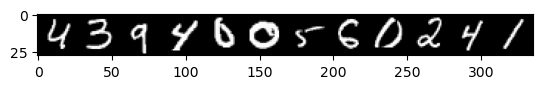

 = 38


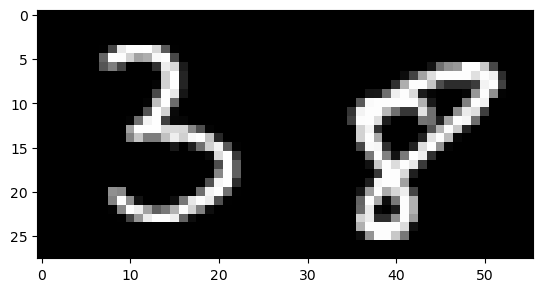

In [14]:
test_addition(adder, [random.randint(0, 9) for _ in range(12)])

In [37]:
number_counts = [2, 4, 8, 16, 32, 64, 128, 256]
test_size = 1000
results = {number_count: 0 for number_count in number_counts}
sum_difference = {number_count: 0 for number_count in number_counts}

for number_count in number_counts:
    print('Number Count:', number_count)
    diff = 0
    for _ in tqdm(range(test_size)):
        number_list = [random.randint(0, 9) for _ in range(number_count)]
        images = torch.stack(get_rand_img_list(adder, number_list))
        pred_sum = adder(images, debug=True)
        real_sum = sum(number_list)
        diff += abs(real_sum - pred_sum)
        if pred_sum == real_sum:
            results[number_count] += 1
    sum_difference[number_count] = diff/test_size


Number Count: 2


100%|██████████| 1000/1000 [00:01<00:00, 514.14it/s]


Number Count: 4


100%|██████████| 1000/1000 [00:03<00:00, 296.03it/s]


Number Count: 8


100%|██████████| 1000/1000 [00:06<00:00, 158.15it/s]


Number Count: 16


100%|██████████| 1000/1000 [00:12<00:00, 78.54it/s]


Number Count: 32


100%|██████████| 1000/1000 [00:24<00:00, 40.57it/s]


Number Count: 64


100%|██████████| 1000/1000 [00:48<00:00, 20.50it/s]


Number Count: 128


100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]


Number Count: 256


100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


In [38]:
results_norm = {str(k) : v / test_size for (k, v) in results.items()}
results_norm

{'2': 0.98,
 '4': 0.968,
 '8': 0.936,
 '16': 0.88,
 '32': 0.759,
 '64': 0.594,
 '128': 0.386,
 '256': 0.17}

In [39]:
avg_difference = {str(k) : v for (k, v) in sum_difference.items()}
avg_difference

{'2': 0.081,
 '4': 0.115,
 '8': 0.248,
 '16': 0.46,
 '32': 0.972,
 '64': 1.686,
 '128': 2.908,
 '256': 4.479}

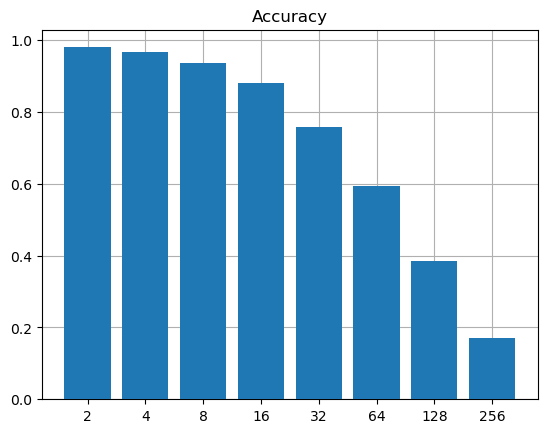

In [40]:
plt.bar(results_norm.keys(), results_norm.values(), zorder=3)
plt.grid(zorder=0)
plt.title('Accuracy')
plt.show()

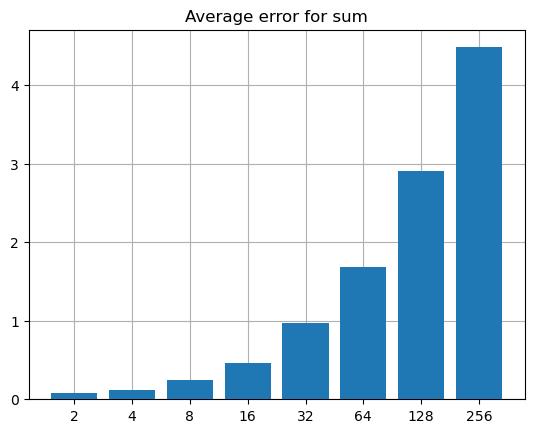

In [41]:
plt.bar(avg_difference.keys(), avg_difference.values(), zorder=3)
plt.grid(zorder=0)
plt.title('Average error for sum')
plt.show()